In [31]:
import os
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.metrics import f1_score, jaccard_score

### Setup Paths & Configuration

In [41]:
DATASET_PATH = "dataset"
IMG_SIZE = (256, 256)  # Image size for training
BATCH_SIZE = 4
EPOCHS = 10
MODEL_PATH = "final_unet_trained.pth"  # Save model path
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Define Dataset Class with Preprocessing

In [5]:
class ManuscriptDataset(Dataset):
    def __init__(self, img_folder, gt_folder, transform=True):
        self.img_folder = img_folder
        self.gt_folder = gt_folder
        self.transform = transform

        self.img_filenames = sorted(os.listdir(img_folder))
        self.gt_filenames = sorted(os.listdir(gt_folder))

        self.augmentations = A.Compose([
            A.Resize(IMG_SIZE[0], IMG_SIZE[1]),
            A.Normalize(mean=[0.5], std=[0.5]),
            A.HorizontalFlip(p=0.5),
            A.RandomBrightnessContrast(p=0.2),
            ToTensorV2()
        ])

    def __len__(self):
        return len(self.img_filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_folder, self.img_filenames[idx])
        gt_path = os.path.join(self.gt_folder, self.gt_filenames[idx])
    
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        gt = cv2.imread(gt_path, cv2.IMREAD_GRAYSCALE) if os.path.exists(gt_path) else np.zeros_like(img)
    
        augmented = self.augmentations(image=img, mask=gt)
        img = augmented["image"]
        gt = augmented["mask"]
    
        # Add a channel dimension to the ground truth
        gt = np.expand_dims(gt, axis=0)  # 🔹 Fix: Make shape [1, H, W]
    
        return img, torch.tensor(gt, dtype=torch.float32)

### Load Data

In [7]:
def get_dataloader(batch_size=BATCH_SIZE):
    train_dataset = ManuscriptDataset(
        img_folder=os.path.join(DATASET_PATH, "img-CB55", "img", "training"),
        gt_folder=os.path.join(DATASET_PATH, "pixel-level-gt-CB55", "pixel-level-gt", "training"),
    )

    val_dataset = ManuscriptDataset(
        img_folder=os.path.join(DATASET_PATH, "img-CB55", "img", "validation"),
        gt_folder=os.path.join(DATASET_PATH, "pixel-level-gt-CB55", "pixel-level-gt", "validation"),
    )

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader

train_loader, val_loader = get_dataloader()

### Define U-Net Model

In [9]:
class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(UNet, self).__init__()

        def conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_c),
                nn.LeakyReLU(0.01),
                nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_c),
                nn.LeakyReLU(0.01),
            )

        def upsample(in_c, out_c):
            return nn.Sequential(
                nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2),
                nn.LeakyReLU(0.01),
            )

        self.encoder1 = conv_block(1, 64)
        self.encoder2 = conv_block(64, 128)
        self.encoder3 = conv_block(128, 256)
        self.encoder4 = conv_block(256, 512)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = conv_block(512, 1024)

        self.upconv4 = upsample(1024, 512)
        self.decoder4 = conv_block(1024, 512)
        self.upconv3 = upsample(512, 256)
        self.decoder3 = conv_block(512, 256)
        self.upconv2 = upsample(256, 128)
        self.decoder2 = conv_block(256, 128)
        self.upconv1 = upsample(128, 64)
        self.decoder1 = conv_block(128, 64)

        self.final = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        e1 = self.encoder1(x)
        e2 = self.encoder2(self.pool(e1))
        e3 = self.encoder3(self.pool(e2))
        e4 = self.encoder4(self.pool(e3))

        b = self.bottleneck(self.pool(e4))

        d4 = self.upconv4(b)
        d4 = torch.cat((d4, e4), dim=1)
        d4 = self.decoder4(d4)

        d3 = self.upconv3(d4)
        d3 = torch.cat((d3, e3), dim=1)
        d3 = self.decoder3(d3)

        d2 = self.upconv2(d3)
        d2 = torch.cat((d2, e2), dim=1)
        d2 = self.decoder2(d2)

        d1 = self.upconv1(d2)
        d1 = torch.cat((d1, e1), dim=1)
        d1 = self.decoder1(d1)

        return torch.sigmoid(self.final(d1))

model = UNet().to(DEVICE)

### Train Model

In [11]:
def train_model(model, train_loader, val_loader, epochs=EPOCHS):
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    criterion = nn.BCEWithLogitsLoss()

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            images, masks = images.to(DEVICE), masks.to(DEVICE)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss / len(train_loader):.4f}")

train_model(model, train_loader, val_loader, epochs=10)
torch.save(model.state_dict(), MODEL_PATH)
print("Model trained and saved!")

Epoch 1/10: 100%|██████████| 5/5 [00:37<00:00,  7.57s/it]


Epoch [1/10], Loss: -1.1227


Epoch 2/10: 100%|██████████| 5/5 [00:32<00:00,  6.60s/it]


Epoch [2/10], Loss: -1.5809


Epoch 3/10: 100%|██████████| 5/5 [00:32<00:00,  6.57s/it]


Epoch [3/10], Loss: -1.7829


Epoch 4/10: 100%|██████████| 5/5 [00:33<00:00,  6.75s/it]


Epoch [4/10], Loss: -1.8840


Epoch 5/10: 100%|██████████| 5/5 [00:36<00:00,  7.37s/it]


Epoch [5/10], Loss: -1.9404


Epoch 6/10: 100%|██████████| 5/5 [00:34<00:00,  6.95s/it]


Epoch [6/10], Loss: -1.9763


Epoch 7/10: 100%|██████████| 5/5 [00:33<00:00,  6.76s/it]


Epoch [7/10], Loss: -1.9902


Epoch 8/10: 100%|██████████| 5/5 [00:34<00:00,  6.93s/it]


Epoch [8/10], Loss: -2.0156


Epoch 9/10: 100%|██████████| 5/5 [00:34<00:00,  6.81s/it]


Epoch [9/10], Loss: -2.0220


Epoch 10/10: 100%|██████████| 5/5 [00:32<00:00,  6.53s/it]

Epoch [10/10], Loss: -2.0393
Model trained and saved!


### Prediction

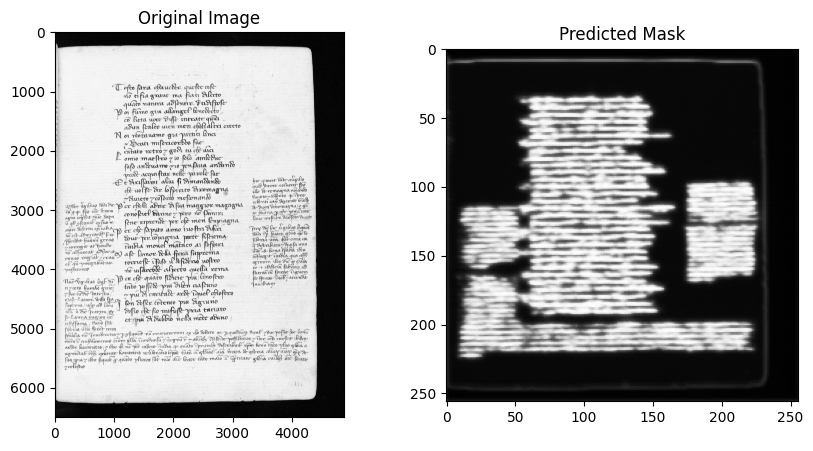

In [20]:
def predict_image(model, image_path):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    if not os.path.exists(image_path):
        raise FileNotFoundError(f"ERROR: Image file not found at {image_path}")

    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    if img is None:
        raise ValueError(f"ERROR: Failed to load image. Ensure {image_path} is a valid image.")

    img = cv2.resize(img, (256, 256)) / 255.0
    img = torch.tensor(img, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)

    with torch.no_grad():
        pred = model(img)
        pred = pred.cpu().squeeze().numpy()

    return pred
    
test_image_path =  r"dataset\img-CB55\img\public-test\e-codices_fmb-cb-0055_0116r_max.jpg"
pred_mask = predict_image(model, test_image_path)

original = cv2.imread(test_image_path, cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(original, cmap="gray")
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(pred_mask, cmap="gray")
plt.title("Predicted Mask")

plt.show()

### Post-Processing

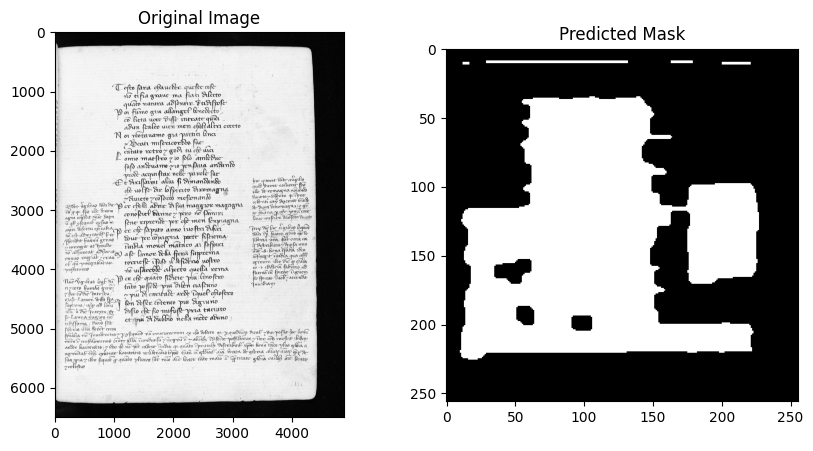

In [23]:
def post_process_mask(mask):
    """Applies advanced morphological operations to refine mask quality."""
    mask = (mask > 0.5).astype(np.uint8)  # Convert to binary

    # Remove small noise (morphological opening)
    kernel_small = np.ones((2, 2), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel_small, iterations=1)

    # Fill gaps (morphological closing)
    kernel_large = np.ones((5, 5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel_large, iterations=2)

    # Apply median blur to smooth edges
    mask = cv2.medianBlur(mask, 3)

    return mask

# Apply the refined post-processing
cleaned_mask = post_process_mask(pred_mask)

original = cv2.imread(test_image_path, cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(original, cmap="gray")
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(cleaned_mask, cmap="gray")
plt.title("Predicted Mask")

plt.show()

### Further Refining

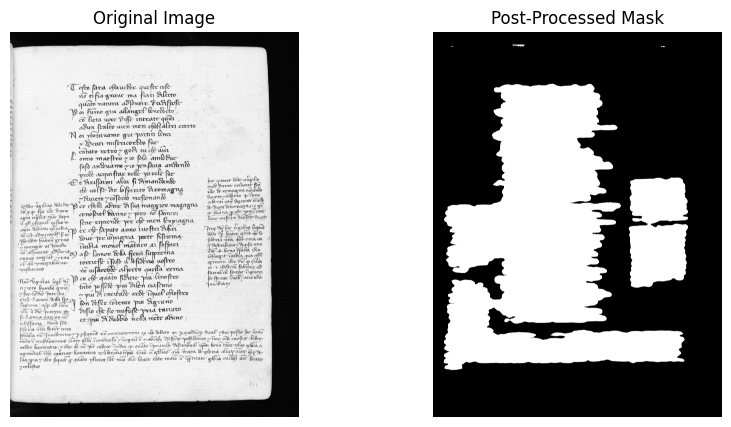

In [25]:
def refine_mask(mask):
    """Post-process mask using thresholding, morphological operations, and contour filtering."""
    mask = (mask * 255).astype(np.uint8)  # Scale to 0-255

    # Apply Otsu's Thresholding
    _, binary_mask = cv2.threshold(mask, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Define a kernel for morphological operations
    kernel = np.ones((3, 3), np.uint8)

    # Apply Closing (connect broken letters)
    closed_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel, iterations=2)

    # Apply Dilation (expand text regions)
    dilated_mask = cv2.dilate(closed_mask, kernel, iterations=2)

    # Find contours
    contours, _ = cv2.findContours(dilated_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Remove unwanted small objects and border artifacts
    filtered_mask = np.zeros_like(dilated_mask)
    h, w = dilated_mask.shape

    for cnt in contours:
        area = cv2.contourArea(cnt)
        x, y, cw, ch = cv2.boundingRect(cnt)

        # Filter out small contours and top-edge artifacts
        if area > 150 and y > 10:  # Remove very small noise & top border artifacts
            cv2.drawContours(filtered_mask, [cnt], -1, 255, thickness=cv2.FILLED)

    return filtered_mask


def predict_image2(model, image_path):
    """Predict segmentation mask using a trained model."""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    if not os.path.exists(image_path):
        raise FileNotFoundError(f" ERROR: Image file not found at {image_path}")

    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f" ERROR: Failed to load image. Ensure {image_path} is a valid image.")

    # Store original size for resizing the output mask
    original_size = img.shape[:2]

    # Preprocess image: Resize, normalize, and convert to tensor
    img_resized = cv2.resize(img, (256, 256)) / 255.0
    img_tensor = torch.tensor(img_resized, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)

    # Predict mask
    with torch.no_grad():
        pred = model(img_tensor)
        pred = pred.cpu().squeeze().numpy()  # Convert to numpy array

    # Resize predicted mask back to original size
    pred_resized = cv2.resize(pred, (original_size[1], original_size[0]))

    # Apply post-processing
    final_mask = refine_mask(pred_resized)

    return final_mask

# File paths
test_image_path = r"dataset\img-CB55\img\public-test\e-codices_fmb-cb-0055_0116r_max.jpg"

# Predict and refine mask
pred_mask = predict_image2(model, test_image_path)

# Load original image
original = cv2.imread(test_image_path, cv2.IMREAD_GRAYSCALE)

# Display results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(original, cmap="gray")
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(pred_mask, cmap="gray")
plt.title("Post-Processed Mask")
plt.axis("off")

plt.show()


### Evaluation

In [39]:
import torch
import cv2
import numpy as np
import os

def dice_coefficient(y_true, y_pred, threshold=0.5):
    """Computes Dice Score (F1 Score for segmentation)."""
    y_pred = (y_pred > threshold).astype(np.uint8)
    y_true = (y_true > threshold).astype(np.uint8)

    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred)

    if union == 0:
        return 1.0 if np.sum(y_true) == 0 else 0.0  # Handle empty masks

    return 2.0 * intersection / union

def iou_score(y_true, y_pred, threshold=0.5):
    """Computes Intersection over Union (IoU, Jaccard Index)."""
    y_pred = (y_pred > threshold).astype(np.uint8)
    y_true = (y_true > threshold).astype(np.uint8)

    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred) - intersection

    return intersection / union if union > 0 else 1.0  # Handle empty masks

def pixel_accuracy(y_true, y_pred, threshold=0.5):
    """Computes pixel-wise accuracy."""
    y_pred = (y_pred > threshold).astype(np.uint8)
    return np.mean(y_true == y_pred)

def evaluate_model(model, test_img_folder, test_gt_folder):
    """Evaluates the model on a test dataset."""
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    dice_scores, iou_scores, pixel_accuracies = [], [], []

    # Print debug information
    print("Images in test_img_folder:", os.listdir(test_img_folder))
    print("Masks in test_gt_folder:", os.listdir(test_gt_folder))

    for img_filename in os.listdir(test_img_folder):
        img_path = os.path.join(test_img_folder, img_filename)
        gt_filename = img_filename.replace('.jpg', '.png')  # Change extension to .png
        gt_path = os.path.join(test_gt_folder, gt_filename)

        if not os.path.exists(gt_path):
            print(f"Skipping {img_filename}: No ground truth mask found.")
            continue

        # Load image and ground truth mask
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        gt = cv2.imread(gt_path, cv2.IMREAD_GRAYSCALE)

        if img is None or gt is None:
            print(f"Skipping {img_filename}: Error loading image/mask.")
            continue

        # Predict mask
        pred_mask = predict_image2(model, img_path)

        # Resize ground truth to match prediction size
        gt_resized = cv2.resize(gt, (pred_mask.shape[1], pred_mask.shape[0]))

        # Compute metrics
        dice = dice_coefficient(gt_resized, pred_mask)
        iou = iou_score(gt_resized, pred_mask)
        acc = pixel_accuracy(gt_resized, pred_mask)

        dice_scores.append(dice)
        iou_scores.append(iou)
        pixel_accuracies.append(acc)

        print(f"{img_filename} - Dice: {dice:.4f}, IoU: {iou:.4f}, Accuracy: {acc:.4f}")

    # Compute average scores if lists are not empty
    if dice_scores:
        avg_dice = np.mean(dice_scores)
        avg_iou = np.mean(iou_scores)
        avg_acc = np.mean(pixel_accuracies)

        print("\nFinal Evaluation Results:")
        print(f"Average Dice Score: {avg_dice:.4f}")
        print(f"Average IoU Score: {avg_iou:.4f}")
        print(f"Average Pixel Accuracy: {avg_acc:.4f}")

        return avg_dice, avg_iou, avg_acc
    else:
        print("\nNo valid images found for evaluation.")
        return None

# Set paths for test images and ground truth masks
test_img_folder = r"dataset\img-CB55\img\public-test"
test_gt_folder = r"dataset\pixel-level-gt-CB55\pixel-level-gt\public-test"

# Load trained model
model = UNet().to(DEVICE)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE, weights_only=True))

# Run evaluation
evaluate_model(model, test_img_folder, test_gt_folder)

Images in test_img_folder: ['e-codices_fmb-cb-0055_0098v_max.jpg', 'e-codices_fmb-cb-0055_0099v_max.jpg', 'e-codices_fmb-cb-0055_0102v_max.jpg', 'e-codices_fmb-cb-0055_0105r_max.jpg', 'e-codices_fmb-cb-0055_0107v_max.jpg', 'e-codices_fmb-cb-0055_0108v_max.jpg', 'e-codices_fmb-cb-0055_0116r_max.jpg', 'e-codices_fmb-cb-0055_0159v_max.jpg', 'e-codices_fmb-cb-0055_0160v_max.jpg', 'e-codices_fmb-cb-0055_0162v_max.jpg']
Masks in test_gt_folder: ['e-codices_fmb-cb-0055_0098v_max.png', 'e-codices_fmb-cb-0055_0099v_max.png', 'e-codices_fmb-cb-0055_0102v_max.png', 'e-codices_fmb-cb-0055_0105r_max.png', 'e-codices_fmb-cb-0055_0107v_max.png', 'e-codices_fmb-cb-0055_0108v_max.png', 'e-codices_fmb-cb-0055_0116r_max.png', 'e-codices_fmb-cb-0055_0159v_max.png', 'e-codices_fmb-cb-0055_0160v_max.png', 'e-codices_fmb-cb-0055_0162v_max.png']
e-codices_fmb-cb-0055_0098v_max.jpg - Dice: 0.3505, IoU: 0.2125, Accuracy: 0.6553
e-codices_fmb-cb-0055_0099v_max.jpg - Dice: 0.3510, IoU: 0.2129, Accuracy: 0.6649
e-

(np.float64(0.3650808858515763),
 np.float64(0.22336332974693307),
 np.float64(0.5998855586006698))